In [1]:
import os
import torch
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import DDPMScheduler, StableDiffusionPipeline

/home/jack/miniconda3/envs/instree/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
concept_path = "/home/jack/Code/Research/instree_main/input_concepts/canada_bear"
paper_token_path = "/home/jack/Code/Research/instree_main/assets/paper_tokens.bin"

In [ ]:
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"
revision  = None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")
weight_dtype = torch.float32

In [3]:
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

In [4]:
# Load tokenizer
tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name_or_path, subfolder="tokenizer")

# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", revision=revision
).to(device)

pipe = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path, torch_dtype=torch.float16, safety_checker=None, requires_safety_checker=False).to(device)

Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 329395.60it/s]


# Functions

In [5]:
def run_prompt(pipe, prompt, num_images_per_seed, seed=0):
    with torch.no_grad():
        torch.manual_seed(seed)
        images = pipe(prompt=[prompt] * num_images_per_seed, num_inference_steps=25, guidance_scale=7.5).images
        np_images = np.hstack([np.asarray(img) for img in images])
        plt.figure(figsize=(10,10))
        plt.imshow(np_images)
        plt.axis("off")
        plt.title(prompt)
        plt.show()

In [6]:
def load_tokens(pipe, data, device):
    """
    Adds the new learned tokens into the predefined dictionary of pipe.
    """
    added_tokens = []
    for t_ in data.keys():
        added_tokens.append(t_)
    num_added_tokens = pipe.tokenizer.add_tokens(added_tokens)
    print(f"Added {num_added_tokens} tokens to the tokenizer.")
    pipe.text_encoder.resize_token_embeddings(len(pipe.tokenizer))
    with torch.no_grad():
        for token_ in data.keys():
            ref_token = pipe.tokenizer.tokenize(token_)
            ref_indx = pipe.tokenizer.convert_tokens_to_ids(ref_token)[0]
            embd_cur = data[token_].to(device).to(dtype=torch.float16)
            pipe.text_encoder.text_model.embeddings.token_embedding.weight[ref_indx] = embd_cur


def load_learned_concepts(pipe, concept_dir, device):
    """
    Loads the learned tokens from the concept directory into the pipe.
    """
    learned_nodes = sorted(os.listdir(concept_dir))
    all_nodes = {}
    print(f"Loading learned nodes from {learned_nodes}...")
    concept = concept_dir.split("/")[-1]
    for node in learned_nodes:
        if os.path.exists(f"{concept_dir}/{node}/embeds.bin"):
            node_code = torch.load(f"{concept_dir}/{node}/embeds.bin")[node]
            all_nodes[f"<{concept}_{node}>"] = node_code

    load_tokens(pipe, all_nodes, device)
    print("Prompts loaded to pipe ...")
    print(all_nodes.keys())

In [43]:
def find_closest_words(word, k=10):
    token_embeds = text_encoder.get_input_embeddings().weight
    word_emb = token_embeds[tokenizer.encode(word, add_special_tokens=False)[0]]
    return find_closest_words_by_emb(word_emb, k)

def find_closest_words_by_emb(word_emb, k=10):
    token_embeds = text_encoder.get_input_embeddings().weight
    token_embeds = F.normalize(token_embeds, p=2, dim=1)
    word_emb = F.normalize(word_emb, p=2, dim=0)
    token_embeds = token_embeds.to(cpu)
    word_emb = word_emb.to(cpu)
    distances = torch.matmul(token_embeds, word_emb)
    closest = distances.argsort(descending=True)
    top_words = tokenizer.convert_ids_to_tokens(closest[:k])
    top_sim = distances[closest[:k]]
    top_sim = [sim.detach().cpu().numpy() for sim in top_sim]
    return list(zip(top_words, top_sim))

In [8]:
def get_embedding(sentence):
    input_id = tokenizer(
        sentence,
        padding="max_length",
        truncation=True,
        max_length=tokenizer.model_max_length,
        return_tensors="pt",
    ).input_ids[0].unsqueeze(0).to(device)
    # print(sentence)
    # print(example["input_ids"]) # [1, 77]
    return text_encoder(input_id)[0] #, position_ids=torch.tensor([[0]*77]).to(device))[0]

def get_word_embedding(word):
    embed = get_embedding(word)
    return embed[0, 1, :]

def get_null_embedding(batch_size=2):
    out = []
    for _ in range(batch_size):
        out.append(get_embedding(""))
    return torch.cat(out, dim=0)

def get_sentence_embedding(sentence, batch_size=2):
    out = []
    for _ in range(batch_size):
        text = random.choice(imagenet_templates_small).format(sentence)
        out.append(get_embedding(text))
    return torch.cat(out, dim=0)

# Generated Image Analysis

100%|██████████| 25/25 [00:08<00:00,  3.11it/s]


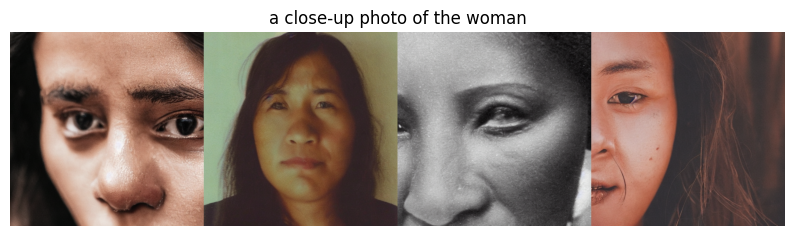

In [10]:
prompt = random.choice(imagenet_templates_small).format("woman")
run_prompt(pipe, prompt, num_images_per_seed=4)

In [13]:
load_learned_concepts(pipe, concept_path, device)

Loading learned nodes from ['v0', 'v1', 'v2']...
Added 2 tokens to the tokenizer.
Prompts loaded to pipe ...
dict_keys(['<canada_bear_v1>', '<canada_bear_v2>'])


100%|██████████| 25/25 [00:08<00:00,  3.11it/s]


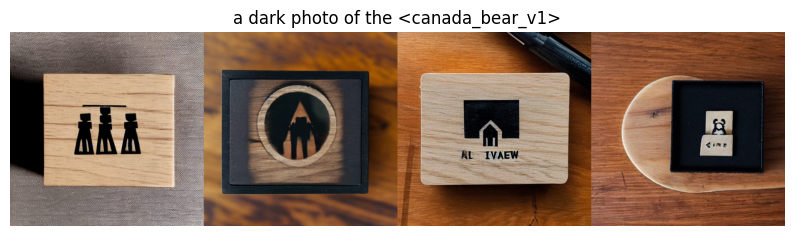

In [14]:
prompt = random.choice(imagenet_templates_small).format("<canada_bear_v1>")
run_prompt(pipe, prompt, 4)

100%|██████████| 25/25 [00:08<00:00,  3.11it/s]


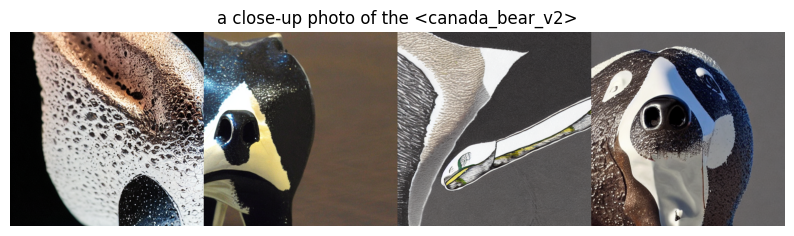

In [15]:
prompt = random.choice(imagenet_templates_small).format("<canada_bear_v2>")
run_prompt(pipe, prompt, 4)

# Text Embedding Analysis

In [22]:
find_closest_words('dog', 10)

[('dog</w>', array(1., dtype=float32)),
 ('dogs</w>', array(0.65084237, dtype=float32)),
 ('dog', array(0.570334, dtype=float32)),
 ('cat</w>', array(0.33908096, dtype=float32)),
 ('dawg</w>', array(0.3307396, dtype=float32)),
 ('doggy</w>', array(0.30392322, dtype=float32)),
 ('dogs', array(0.283666, dtype=float32)),
 ('puppy</w>', array(0.28261265, dtype=float32)),
 ('dogg</w>', array(0.27381968, dtype=float32)),
 ('doggo</w>', array(0.26527432, dtype=float32))]

In [24]:
find_closest_words('<canada_bear_v1>', 10)

[('<</w>', array(1., dtype=float32)),
 ('</</w>', array(0.39441574, dtype=float32)),
 ('<<</w>', array(0.38984475, dtype=float32)),
 ('.<</w>', array(0.37077734, dtype=float32)),
 ('<', array(0.35751137, dtype=float32)),
 ('âĿ¤</w>', array(0.33030787, dtype=float32)),
 ('âĿ¤ï¸ı</w>', array(0.30979142, dtype=float32)),
 (':</w>', array(0.30188668, dtype=float32)),
 ('<<<</w>', array(0.286567, dtype=float32)),
 ('âĻ¥</w>', array(0.28030726, dtype=float32))]

In [25]:
print(get_word_embedding('dog').shape) # 768
print(get_null_embedding().shape) # bs x 77 x 768, 77 = <bos> + <eos> * 76
print(get_sentence_embedding("dog").shape) # bs x 77 x 768

torch.Size([768])
torch.Size([2, 77, 768])
torch.Size([2, 77, 768])


In [46]:
paper_token = torch.load(paper_token_path)
print(paper_token.keys())
print(paper_token['cat'].keys())
find_closest_words_by_emb(paper_token['cat']['<cat_v1>'], 10)

dict_keys(['cat', 'bear', 'buddha', 'mug', 'teapot', 'round_bird', 'elephant', 'wooden_pot', 'physics_mug', 'red_teapot', 'mug_buildings'])
dict_keys(['<cat_v1>', '<cat_v2>', '<cat_v3>', '<cat_v4>', '<cat_v5>', '<cat_v6>'])


[('phdlife</w>', array(0.18158428, dtype=float32)),
 ('vijaysethu', array(0.17599145, dtype=float32)),
 ('theforceawakens</w>', array(0.17451024, dtype=float32)),
 ('disciplines</w>', array(0.17331208, dtype=float32)),
 ('bengaluru</w>', array(0.17285636, dtype=float32)),
 ('paella</w>', array(0.1707069, dtype=float32)),
 ('defender</w>', array(0.16851813, dtype=float32)),
 ('aguero</w>', array(0.16841856, dtype=float32)),
 ('daffodils</w>', array(0.16614509, dtype=float32)),
 ('directs</w>', array(0.1653325, dtype=float32))]